In [1]:
#Basic setups 
import numpy as np
from skimage import io
%matplotlib inline
import matplotlib.pyplot as plt

In [24]:
from dataloader import load_data
from PCA import PCA


In [328]:
from random import shuffle
import math
def kFold(K,data):
    """This function is used to implement k-fold cross-validation"""
    #Shuffle the dataset to get more accurate performance
    index = np.arange(0,len(data))
    shuffle(index)
    shuffled_data= data[index]
    
    
    #shuffled_data = data
    
    
    
    print("original shape:",data.shape)
    print("shuffled shape:",shuffled_data.shape)
    
    #Split the data into training, testing and handout set
    size = len(data)
    set_size = math.floor(size/K)
    index_train = int(set_size*(K-2))
    index_test = int(set_size*(K-1))

    
    training_set = shuffled_data[:index_train]
    testing_set = shuffled_data[index_train:index_test]
    val_set = shuffled_data[index_test:]
    print("trainshape:",training_set.shape)
    return training_set,testing_set,val_set



In [329]:
def img_flatten(img):
    """This function is used to convert 2-D images to 1-D vectors"""
    flatten_img = []
    for i in range(len(img)):
        flatten_img.append(img[i].flatten())
    return np.array(flatten_img)

In [330]:
def projectPC(x,mean_image, eigen_values, eigen_vectors):
    """This function is used to project the data x on the given training set x_train"""
    msd = x - mean_image
    projected_image = np.matmul(msd,eigen_vectors)/eigen_values
    projected = np.insert(projected_image,0,1,axis=1)
    return projected

In [331]:

def sigmoid(x):
    return 1 / (1 + np.exp(-x))



def accuracy(x,y,weight):
    x = np.asmatrix(x)
    y = np.asmatrix(y)
    weight = np.asmatrix(weight)
    
    y_hat = sigmoid(x * weight.T)
    #print("shape of y_hat",y_hat.shape)
    
    prediction =  [0 if m < 0.5 else 1 for m in y_hat] 
    
    correct = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        if y[i]-prediction[i]==0:
            correct[i]=1
    accuracy = sum(correct)/len(correct) 
    return accuracy
    
def cross_entropy(x,y,weight):
    x = np.asmatrix(x)
    y = np.asmatrix(y)
    weight = np.asmatrix(weight)
    
    #print(weight.shape)
    
    y_hat = sigmoid(x*weight.T)
    
    #print("shape of y,y_hat",y.shape,y_hat.shape)
    
    cost = np.multiply(-y,np.log(y_hat))-np.multiply((1-y),np.log(1-y_hat))
    
    error = np.sum(cost)/len(x)
    return error

def gradientDescent(x,y,weight,learning_rate):
    x = np.asmatrix(x)
    y = np.asmatrix(y)
    weight = np.asmatrix(weight)
    
    #print("checkgradD,weightshape:",weight.shape)
    
    y_hat = sigmoid(x*weight.T)
    error = y_hat-y
    
    gradient = x.T * error / len(x)
    gradient= np.squeeze(np.asarray(gradient))
    
    #print("checkgradD,gradientshape:",weight.shape)
    
    weight_updated = weight - learning_rate*gradient
    weight_updated = np.asarray(weight_updated)
    
    #print("checkgradD,weightshapeupdate:",weight_updated.shape)
    
    return gradient,weight_updated
    

In [339]:
#Load data 
data,cnt = load_data("./resized/")


minivan= data.get('Minivan')
convertible = data.get('Convertible')

minivan_flatten = img_flatten(minivan)
convertible_flatten = img_flatten(convertible)

print("shape of minivan:",minivan_flatten.shape)
print("shape of convertible:",convertible_flatten.shape)

#Split data into train,test and val set
num_fold = 10
trainM,testM,valM = kFold(num_fold,minivan_flatten)
trainC,testC,valC = kFold(num_fold,convertible_flatten)




train = np.concatenate((trainM, trainC),axis=0)
test = np.concatenate((testM, testC),axis=0)
val = np.concatenate((valM, valC),axis=0)

y_train = np.concatenate((np.ones(len(trainM)), np.zeros(len(trainC))), axis=0)
y_train= np.array([[i] for i in y_train])

y_test = np.concatenate((np.ones(len(testM)), np.zeros(len(testC))), axis=0)
y_test = np.array([[i] for i in y_test])

y_val = np.concatenate((np.ones(len(valM)), np.zeros(len(valC))), axis=0)
y_val = np.array([[i] for i in y_val])

print("shape of train,test and val set:",train.shape,test.shape,val.shape)
print("shape of y for train,test and val:",y_train.shape,y_test.shape,y_val.shape)

#Perform PCA to find top PCs on training set
num_PC = 20
projected, mean_image, top_sqrt_eigen_values, top_eigen_vectors = PCA(train, num_PC)
x_train = np.insert(projected, 0, 1, axis=1)

#Project test and val set on top PCs
x_test = projectPC(test,mean_image, top_sqrt_eigen_values, top_eigen_vectors)
x_val = projectPC(val,mean_image, top_sqrt_eigen_values, top_eigen_vectors)

print("shape of x_train,x_test and x_val :",x_train.shape,x_test.shape,x_val.shape)

Car types: ['Convertible', 'Minivan'] 

Convertible: 150 # of images
Minivan: 150 # of images
shape of minivan: (150, 60000)
shape of convertible: (150, 60000)
original shape: (150, 60000)
shuffled shape: (150, 60000)
trainshape: (120, 60000)
original shape: (150, 60000)
shuffled shape: (150, 60000)
trainshape: (120, 60000)
shape of train,test and val set: (240, 60000) (30, 60000) (30, 60000)
shape of y for train,test and val: (240, 1) (30, 1) (30, 1)
shape of x_train,x_test and x_val : (240, 21) (30, 21) (30, 21)


In [340]:
max_iter = 800
learning_rate = 5

train_error = np.zeros((max_iter,1))
val_error = np.zeros((max_iter,1))
test_error = np.zeros((max_iter,1))
            
train_acc = np.zeros((max_iter,1))
val_acc=np.zeros((max_iter,1))
test_acc = np.zeros((max_iter,1))

weight = np.zeros(len(x_train[0]))
for i in range(max_iter):
    grad,weight = gradientDescent(x_train,y_train,weight,learning_rate)
    
    #print("shape of weight",weight.shape)
    
    train_error[i] = cross_entropy(x_train,y_train,weight)
    train_acc[i] = accuracy(x_train,y_train,weight)
                                                 
    #Calculate the error for hold out set using updated weight
    val_error[i] = cross_entropy(x_val,y_val,weight)
    val_acc[i] = accuracy(x_val,y_val,weight)
                                                 
                
    #Calculate the error for test set using updated weight
    test_error[i] = cross_entropy(x_test,y_test,weight)
    test_acc[i] = accuracy(x_test,y_test,weight)

    

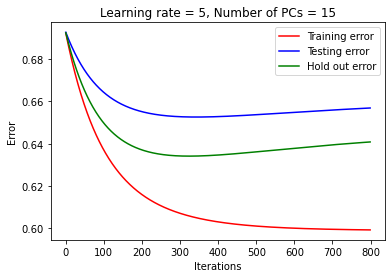

In [341]:
#Plot error/accuracy 
plt.plot(train_error,color = 'red',label = 'Training error')
plt.plot(test_error,color = 'blue',label = 'Testing error')
plt.plot(val_error,color = 'green',label = 'Hold out error')
plt.title("Learning rate = 5, Number of PCs = 15")
plt.ylabel('Error')
plt.xlabel('Iterations')
plt.legend()
plt.savefig('./plots/5b_error.png')
plt.show()

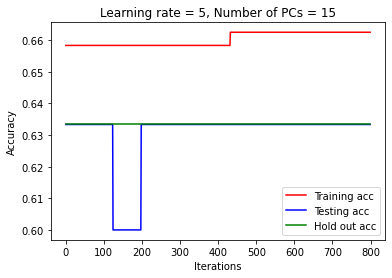

In [342]:
plt.plot(train_acc,color = 'red',label = 'Training acc')
plt.plot(test_acc,color = 'blue',label = 'Testing acc')
plt.plot(val_acc,color = 'green',label = 'Hold out acc')
plt.title("Learning rate = 5, Number of PCs = 15")
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.legend()
plt.savefig('./plots/5b_acc.png')
plt.show()

In [343]:
#Find test accuracy
index_min = np.argmin(val_error)
test_accuracy = test_acc[index_min]
print("The test accuracy is :",test_accuracy)

The test accuracy is : [0.63333333]


In [357]:
#Plot top 4 PCs
def plot_top_PCs(eigenvectors,n):
    """This function is used plot top PCs"""
    imgs = []
    plt.figure()
    for i in range(n):
        eigen = eigenvectors[:,i]
        image = np.reshape(eigen,(200,300))
        imgs.append(image)
        plt.subplot(2,n/2,i+1)
        plt.imshow(imgs[i])

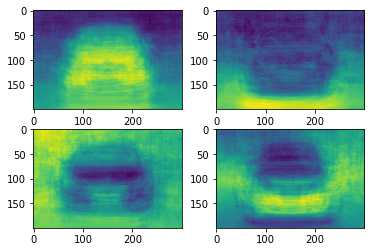

In [359]:
plot_top_PCs(top_eigen_vectors,4)
plt.savefig('./plots/5b_top4eign.png')